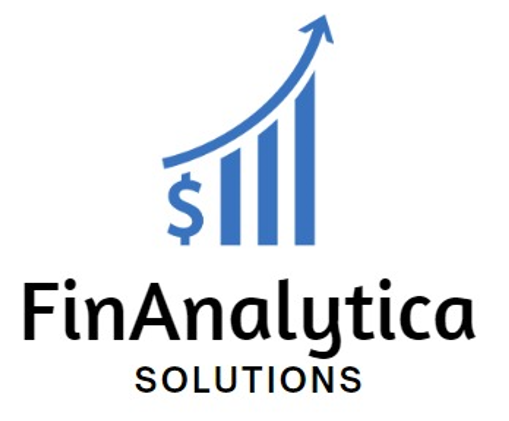

 **ROL: DATA ENGINEER**

**OBJETIVOS**


> Los objetivos principales que llevaron a cabo los ingenieros de datos a cargo para este proyecto fueron:


*   Investigar sobre que fuente de datos usar para el proyecto.
*   Diseñar y mantener una pipeline de datos eficiente.
*   Brindar soporte al equipo de Analytics y Machine Learning, ofreciendo asistencia sobre problemas relacionados a la ingesta de datos o cualquier otro aspecto técnico.








**FUENTE DE DATOS SELECCIONADA**


> Se eligió como fuente de datos "Yahoo Finance" https://finance.yahoo.com/
y mediante las bibliotecas pandas_datareader y yfinance podemos extraer los datos que necesitamos.




In [ ]:
import pandas as pd
from pandas_datareader import data as pdr
import yfinance as yfin
from datetime import datetime

hoy = datetime.today().strftime('%Y-%m-%d')
yfin.pdr_override()

# Lista de empresas
companies = ['NFLX', 'GOOG', 'AMZN','TSLA','ALUA.BA','MELI','GLOB','KO','YPF','MSFT','TS','SBUX','MCD']

# DataFrame para almacenar todos los datos
all_data = pd.DataFrame()

for empresa in companies:
    # Obtener los datos de la empresa actual
    data = pdr.get_data_yahoo(empresa, start='2019-01-01', end=hoy)

    # Agregar la columna 'Company' con el nombre de la empresa
    data['Company'] = empresa

    # Agregar los datos al DataFrame principal
    all_data = pd.concat([all_data, data])

# Si 'Date' no está en el índice, intentamos reindexar para obtenerlo
if 'Date' not in all_data.columns:
    all_data.reset_index(inplace=True)

# Reorganizar el orden de las columnas
all_data = all_data[['Date', 'Company', 'Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume']]

# Guardar el DataFrame como un archivo CSV en tu computadora
csv_file = 'stock_data.csv'
all_data.to_csv(csv_file, index=False)

print(f"Los datos se han guardado en el archivo CSV: {csv_file}")

**BASE DE DATOS SELECCIONADA**


>Se optó por comodidad y facilidad de acceso BigQuery
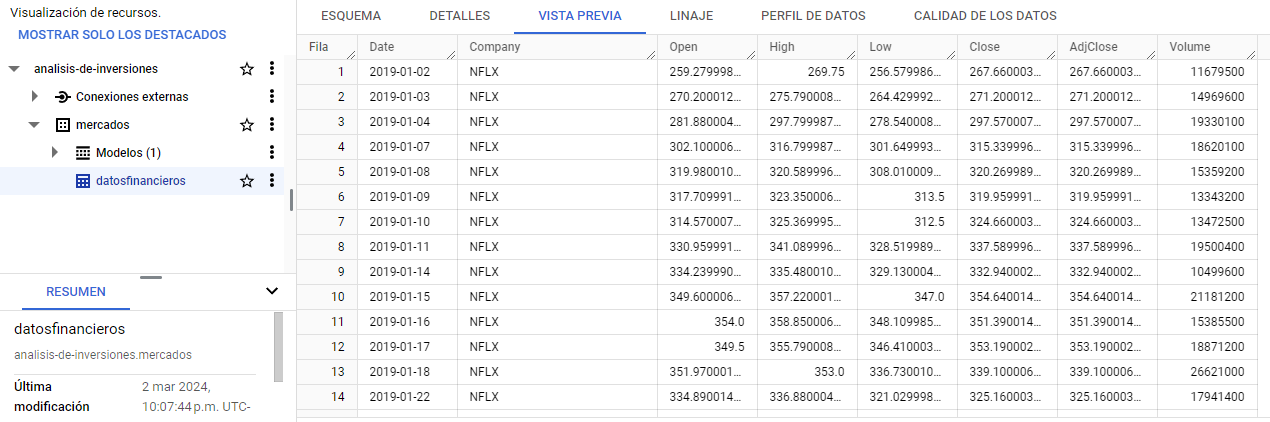


**DISEÑO DE LA PIPELINE**


**1.   CREACIÓN DEL ENTORNO**


> Se utilizó Cloud Composer como gestor de flujo de datos, esto nos brinda una mayor facilidad para trabajar con BigQuery ya que ambos pertenecen a Google Cloud.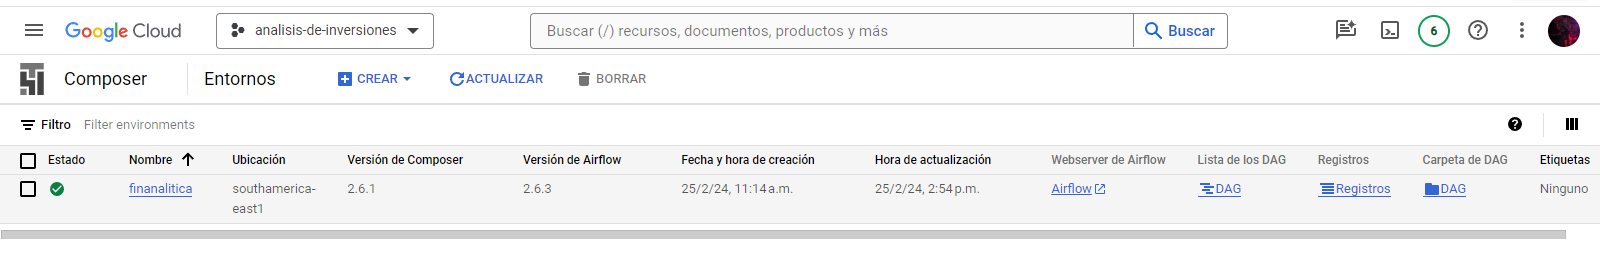


**2.   DISEÑAR LA PIPELINE EN APACHE AIRFLOW**












> **GRAFO ACÍCLIDO DIRIGIDO (DAG)**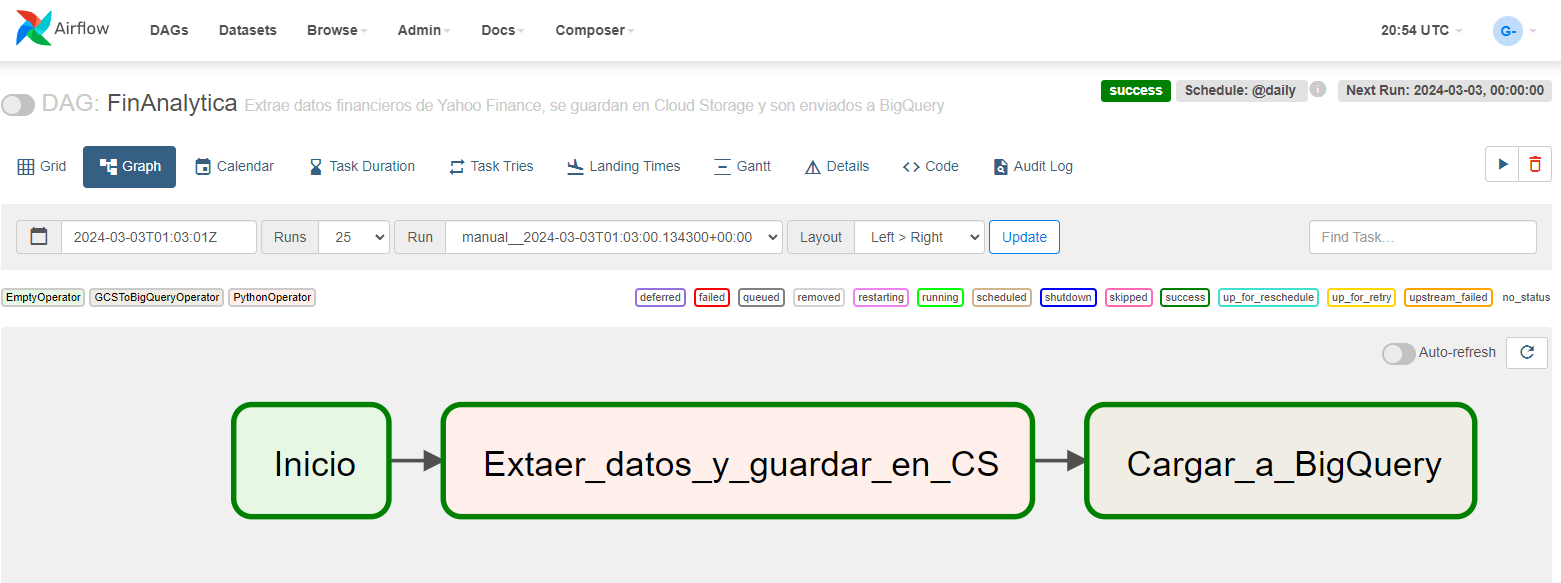



In [ ]:
from airflow import DAG
from airflow.operators.python_operator import PythonOperator
from airflow.operators.dummy_operator import DummyOperator
from airflow.providers.google.cloud.transfers.gcs_to_bigquery import GCSToBigQueryOperator
from google.cloud import storage
from datetime import datetime, timedelta
import pandas as pd
from pandas_datareader import data as pdr
import yfinance as yfin

default_args = {
    'owner': 'airflow',
    'depends_on_past': False,
    'start_date': datetime(2024, 2, 19),
    'email_on_failure': False,
    'email_on_retry': False,
    'retries': 1,
    'retry_delay': timedelta(minutes=5),
}

dag = DAG(
    dag_id="FinAnalytica",
    default_args=default_args,
    description='Extrae datos financieros de Yahoo Finance, se guardan en Cloud Storage y son enviados a BigQuery',
    schedule_interval="@daily",
)

def download_and_upload_to_cloud_storage():
    hoy = datetime.today().strftime('%Y-%m-%d')
    yfin.pdr_override()
    companies = ['NFLX', 'GOOG', 'AMZN','TSLA','ALUA.BA','MELI','GLOB','KO','YPF','MSFT','TS','SBUX','MCD']
    all_data = pd.DataFrame()

    for empresa in companies:
        data = pdr.get_data_yahoo(empresa, start='2019-01-01', end=hoy)
        data['Company'] = empresa
        all_data = pd.concat([all_data, data])
    if 'Date' not in all_data.columns:
        all_data.reset_index(inplace=True)

    all_data = all_data[['Date', 'Company', 'Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume']]
    csv_file = 'stock_data.csv'
    all_data.to_csv(csv_file, index=False)
    bucket_name = 'southamerica-east1-finanali-a1e53f00-bucket'
    destination_blob_name = 'stock_data.csv'
    storage_client = storage.Client()
    bucket = storage_client.bucket(bucket_name)
    blob = bucket.blob(destination_blob_name)
    blob.upload_from_filename(csv_file)

    print(f"Los datos se han guardado en Cloud Storage: gs://{bucket_name}/{destination_blob_name}")

def load_to_bigquery():
    task_gcs_to_bigquery = GCSToBigQueryOperator(
        task_id='Cargar_a_BigQuery',
        bucket='southamerica-east1-finanali-a1e53f00-bucket',
        source_objects=['stock_data.csv'],
        destination_project_dataset_table='analisis-de-inversiones.mercados.datosfinancieros',
        source_format="CSV",
        skip_leading_rows=1,
        write_disposition="WRITE_TRUNCATE",
        autodetect=False,
        encoding="UTF-8",
        schema_object="esquema.json",

    )

    return task_gcs_to_bigquery

with dag:
    task_inicio = DummyOperator(
        task_id="Inicio"
    )

    task_download_and_upload = PythonOperator(
        task_id='Extaer_datos_y_guardar_en_CS',
        python_callable=download_and_upload_to_cloud_storage,
    )

    task_load_to_bigquery = load_to_bigquery()

    task_inicio >> task_download_and_upload >> task_load_to_bigquery

In [ ]:
esquema.json utilizado

[
    {
        "name": "Date",
        "type": "DATE",
        "mode": "REQUIRED"
    },
    {
        "name": "Company",
        "type": "STRING",
        "mode": "NULLABLE"
    },
    {
        "name": "Open",
        "type": "FLOAT",
        "mode": "NULLABLE"
    },
    {
        "name": "High",
        "type": "FLOAT",
        "mode": "NULLABLE"
    },
    {
        "name": "Low",
        "type": "FLOAT",
        "mode": "NULLABLE"
    },
    {
        "name": "Close",
        "type": "FLOAT",
        "mode": "NULLABLE"
    },
    {
        "name": "AdjClose",
        "type": "FLOAT",
        "mode": "NULLABLE"
    },
    {
        "name": "Volume",
        "type": "INTEGER",
        "mode": "NULLABLE"
    }
]